## Imports

In [1]:
import os
import random
import csv

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import keras
from keras.utils import to_categorical
from keras.models import Model
from keras.optimizers import Adam
from keras import metrics
from keras import regularizers
from keras.layers import Dense, AveragePooling2D, Flatten
from keras.layers import Input, concatenate, Conv2D, BatchNormalization, Activation

from sklearn.utils import class_weight

Using TensorFlow backend.


## Select GPU

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="4"

## Data path

In [ ]:
data_path = 'data/data_package01/sensor-01/scc/'

In [ ]:
class_names = ['SCC_below_56', 'SCC_56-132', 'SCC_above_132']

## Processing data

In [ ]:
def get_unq_id(images_list):
    id_list = []
    for image_name in images_list:
        id_list.append(image_name[:-6])    
    unq_id_list = list(set(id_list))
    return unq_id_list

In [ ]:
unq_data_dict = {}
class_map = {}
for i, class_name in enumerate(class_names):
    print class_name
    class_map[i] = class_name
    images_list = os.listdir(os.path.join(data_path, class_name))
    unq_id_list = get_unq_id(images_list)
    unq_data_dict[i] = unq_id_list

## Stratified splitting into Train and Val set

In [ ]:
val_fraction = 0.2 #fraction of data to be used for validation

In [ ]:
unq_train_data_dict = {}
unq_val_data_dict = {}
## Since we have 5 images from same sample. It is not good to have some images in 
## train and other in val for the sample. So train and val split is done based on sample ID.
for class_number, unq_id_list in unq_data_dict.items():
    total_ids = len(unq_id_list)
    num_train_ids = int((1-val_fraction)*total_ids)
    num_val_ids = total_ids - num_train_ids
    
    train_id_list = random.sample(unq_id_list, num_train_ids)
    val_id_list = []
    for unq_id in unq_id_list:
        if unq_id not in train_id_list:
            val_id_list.append(unq_id)
    
    unq_train_data_dict[class_number] = train_id_list
    unq_val_data_dict[class_number] = val_id_list

In [ ]:
trainX = []
valX = []
trainY = []
valY = []

In [ ]:
## Images are resized to 640x240.

for class_number, unq_id_list in unq_train_data_dict.items():
    class_name = class_map[class_number]
    for unq_id in unq_id_list:
        for i in range(5):
            img_name = unq_id + "_"+ str(i)+ ".png"
            
            img_path = os.path.join(data_path, class_name,img_name)
            img = Image.open(img_path)
            img = img.resize(size=(640,240))
            img_array = np.asarray(img)
            
            trainX.append(img_array)
            trainY.append(class_number)

In [ ]:
# Randomly shuffle training data
c = list(zip(trainX, trainY))
random.shuffle(c)
trainX, trainY = zip(*c)

In [ ]:
for class_number, unq_id_list in unq_val_data_dict.items():
    class_name = class_map[class_number]
    for unq_id in unq_id_list:
        for i in range(5):
            img_name = unq_id + "_"+ str(i)+ ".png"
            
            img_path = os.path.join(data_path, class_name,img_name)
            img = Image.open(img_path)
            img = img.resize(size=(640,240))
            img_array = np.asarray(img)
            
            valX.append(img_array)
            valY.append(class_number)

In [ ]:
## compute class weights to account for label imbalance

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(trainY),
                                                 trainY)

In [ ]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=3)
valY = to_categorical(valY, num_classes=3)

In [ ]:
trainX = np.asarray(trainX)
valX = np.asarray(valX)

In [ ]:
# save data in numpy array for later use
np.savez("train_val_data_v3.npz", trainX, trainY, valX, valY, class_weights)

In [4]:
## load data if it is already saved

# data = np.load("train_val_data_v3.npz")
# trainX = data["arr_0"]
# trainY = data["arr_1"]
# valX = data["arr_2"]
# valY = data["arr_3"]
# class_weights = data["arr_4"]

# preprocess image data : subtract mean and scale std


In [ ]:
## We train a model with two inputs. One for processing LED part of the images and other for processing laser part.
## hence we separate each image into two parts and then preprocess them.

In [5]:
trainX_blue = trainX[:,:,:320,:]
trainX_red = trainX[:,:,320:,:]

In [6]:
valX_blue = valX[:,:,:320,:]
valX_red = valX[:,:,320:,:]

In [7]:
def preprocess_train_data(X):
    # subtract channel mean and divide by standard deviation
    X = X.astype(float)
    mean_X = np.mean(X, axis = (0,1,2))
    X -= mean_X
    std_X = np.std(X, axis = (0,1,2))
    X /= std_X
    return X, mean_X, std_X

In [8]:
def preprocess_val_data(X, mean_X, std_X):
    # preprocess validation data using mean and std from train data
    X = X.astype(float)
    X -= mean_X
    X /= std_X
    return X

In [9]:
trainX_blue_normalized, mean_blue, std_blue = preprocess_train_data(trainX_blue)
trainX_red_normalized, mean_red, std_red = preprocess_train_data(trainX_red)

In [10]:
valX_blue = preprocess_val_data(valX_blue, mean_blue, std_blue)
valX_red = preprocess_val_data(valX_red, mean_red, std_red)

## Prepare Model

In [11]:
# weight l2 regularization to avoid overfitting of the model
l2_reg = regularizers.l2(0.1)

In [ ]:
## Given only couple thousand images for training, a very shallow model with few thousand parameters was trained.
# The model has two parallel streams that have identical architecture for processing red and blue part of the image.

In [12]:
input_1 = Input(shape=(240,320,3), name='input1')
input_2 = Input(shape=(240,320,3), name='input2')

In [13]:
x= Conv2D(4, kernel_size=(3,3), kernel_regularizer=l2_reg)(input_1)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x= Conv2D(4, kernel_size=(3,3), kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = AveragePooling2D(pool_size=(2,2))(x)

x= Conv2D(8, kernel_size=(3,3), kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = AveragePooling2D(pool_size=(2,2))(x)

x= Conv2D(8, kernel_size=(3,3), kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = AveragePooling2D(pool_size=(2,2))(x)

x= Conv2D(8, kernel_size=(3,3), kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = AveragePooling2D(pool_size=(2,2))(x)
output_1 = Flatten()(x)

In [14]:
x= Conv2D(4, kernel_size=(3,3), kernel_regularizer=l2_reg)(input_2)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x= Conv2D(4, kernel_size=(3,3), kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = AveragePooling2D(pool_size=(2,2))(x)

x= Conv2D(8, kernel_size=(3,3), kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = AveragePooling2D(pool_size=(2,2))(x)

x= Conv2D(8, kernel_size=(3,3), kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = AveragePooling2D(pool_size=(2,2))(x)

x= Conv2D(8, kernel_size=(3,3), kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = AveragePooling2D(pool_size=(2,2))(x)
output_2 = Flatten()(x)

In [15]:
# combine outputs from two streams

x = concatenate([output_1, output_2])
output = Dense(3, activation='softmax', kernel_regularizer=l2_reg)(x) # 3 class model

In [16]:
model = Model(inputs=[input_1, input_2], outputs=output)

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 238, 318, 4)  112         input1[0][0]                     
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 238, 318, 4)  112         input2[0][0]                     
__________________________________________________________________________________________________
batch_norm

In [18]:
# cross entropy loss function is used because it is a multiclass model.
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [19]:
# callbacks to checkpoint models, save logs and early stopping to monitor val loss

checkpoint_callback = keras.callbacks.ModelCheckpoint("exp4/weights.{epoch:02d}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
csvlogger_callback = keras.callbacks.CSVLogger("exp4/logs.csv", separator=',', append=False)
earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None)

callbacks = [checkpoint_callback, csvlogger_callback, earlystopping_callback]

In [20]:
history = model.fit(x=[trainX_blue_normalized, trainX_red_normalized], y=trainY, batch_size=1, epochs=1000, verbose=1, validation_data=([valX_blue, valX_red], valY), callbacks=callbacks, class_weight=class_weights)

Train on 1920 samples, validate on 490 samples
Epoch 1/1000
1920/1920 [==============================] - 60s 31ms/step - loss: 5.2683 - acc: 0.5755 - val_loss: 3.9790 - val_acc: 0.5673
Epoch 2/1000
1920/1920 [==============================] - 57s 30ms/step - loss: 3.2885 - acc: 0.5719 - val_loss: 2.8429 - val_acc: 0.5531
Epoch 3/1000
1920/1920 [==============================] - 57s 30ms/step - loss: 2.4571 - acc: 0.5849 - val_loss: 2.2653 - val_acc: 0.5449
Epoch 4/1000
1920/1920 [==============================] - 57s 30ms/step - loss: 2.0291 - acc: 0.5797 - val_loss: 1.9732 - val_acc: 0.5612
Epoch 5/1000
1920/1920 [==============================] - 57s 30ms/step - loss: 1.7565 - acc: 0.5865 - val_loss: 1.8153 - val_acc: 0.5673
Epoch 6/1000
1920/1920 [==============================] - 57s 30ms/step - loss: 1.5855 - acc: 0.5938 - val_loss: 1.7580 - val_acc: 0.5673
Epoch 7/1000
1920/1920 [==============================] - 57s 30ms/step - loss: 1.4678 - acc: 0.6026 - val_loss: 1.5447 - val

KeyboardInterrupt: 

## Read Logs file

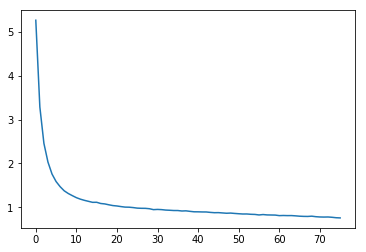

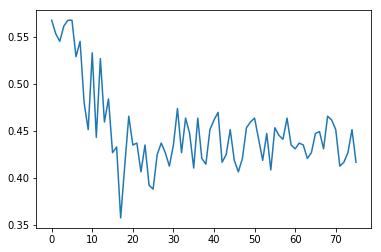

best_epoch : 18


In [41]:
# Read logs file to look at loss curves and get best epoch

with open("exp4/logs.csv",'r') as f:
    data_iter = csv.reader(f,delimiter = ',')
    data = [data for data in data_iter]
    
train_loss = [float(line[2]) for line in data[1:]]
val_loss = [float(line[3]) for line in data[1:]]

plt.plot(train_loss)
plt.show()

plt.plot(val_loss)
plt.show()

print "best_epoch : {}".format(np.argmin(val_loss)+1)